# Evaluation of the sensitivity of the statistical test
The objective of this notebook is to assess the sensitivity of the statistical test detecting a significant change of signatures between the clones. To achieve that, for each possible number of clones between 2 and 6, 30 alternative $\pi$ matrices (the mixture of signatures for each clone) were drawn such that their maximal cosine distance between each clone's profile is thouroughly sampled between 0 and 0.5, with enough points below 0.1, where sensitivity changes dramatically with the maximum distance. For each case, the number of mutations varies among $\{100, 300, 1000\}$, the diploid proportion of the genome $\{0.1, 0.5, 0.9\}$, and the sequencing depth $\{100, 500\}$.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
import os
from statsmodels.stats.multitest import multipletests
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import collections

pd.options.display.max_columns = 200
phd_folder_path = '/Users/JudithAbecassis/Documents/PhD'
os.chdir('{}/TCGA_signatures'.format(phd_folder_path))
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
clonesig_res = pd.read_csv('201907824_eval_clonesig_power_statistical_test_sensitivity.csv', sep='\t')

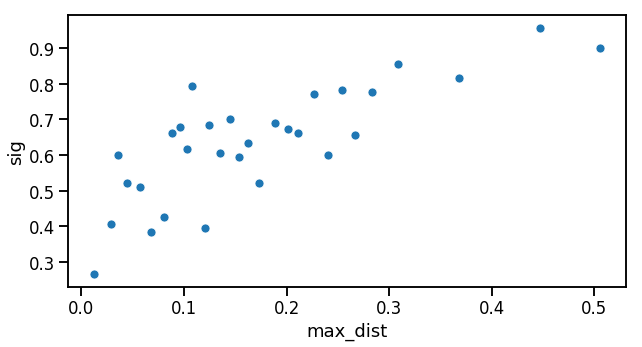

In [4]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )
clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
subdata=pd.DataFrame(clonesig_resb.groupby('max_dist_y').sig.sum()/clonesig_resb.groupby('max_dist_y').sig.count())
subdata = subdata.assign(max_dist=subdata.index)
plt.figure(figsize=(10,5))
sns.scatterplot(x='max_dist', y='sig', data=subdata)

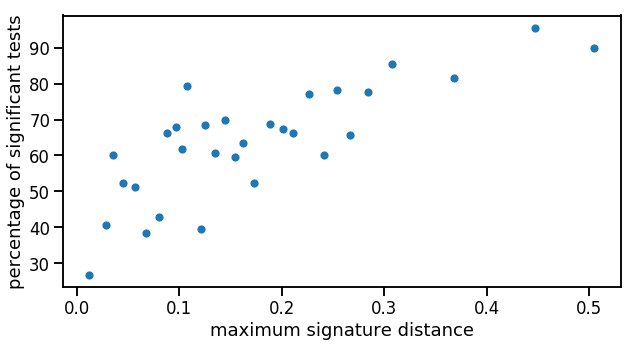

In [5]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )

clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
clonesig_resb['max_dist_y'] = np.round(clonesig_resb['max_dist_y'], 3)
subdata=pd.DataFrame(clonesig_resb.groupby('max_dist_y').sig.sum()/clonesig_resb.groupby('max_dist_y').sig.count()) * 100
subdata = subdata.assign(max_dist=subdata.index)
plt.figure(figsize=(10,5))
ax=sns.scatterplot(x='max_dist', y='sig', data=subdata)
ax.set_xlabel('maximum signature distance')
ax.set_ylabel('percentage of significant tests')
plt.savefig('20190801_paper_figures/overall_test_sensitivity.pdf', bbox_inches='tight')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

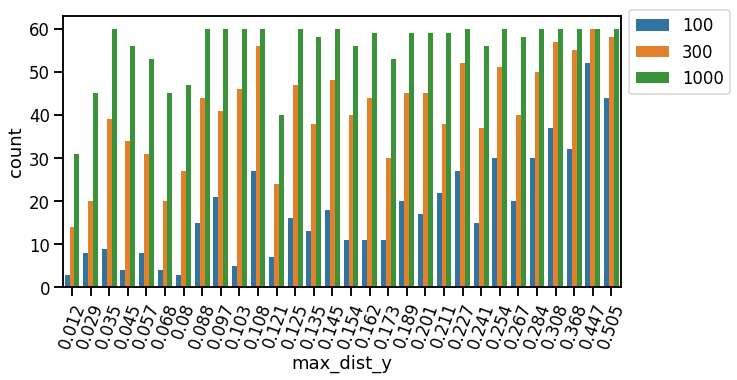

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x="max_dist_y", hue="nb_mut", data=clonesig_resb[clonesig_resb.sig])
plt.legend(loc=2, bbox_to_anchor=(1,1.05))
plt.xticks(rotation=70, ha='center')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

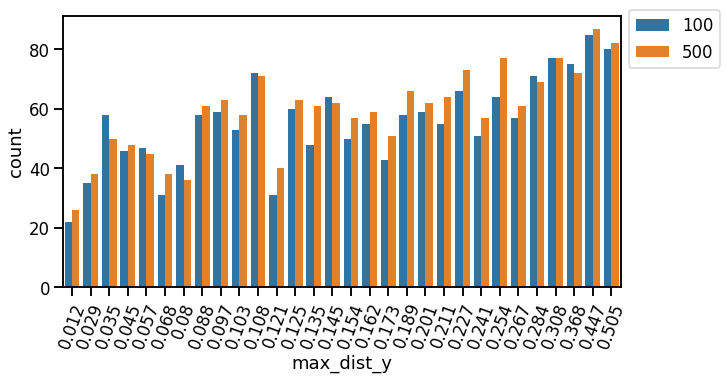

In [61]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x="max_dist_y", hue="depth", data=clonesig_resb[clonesig_resb.sig])
plt.legend(loc=2, bbox_to_anchor=(1,1.05))
plt.xticks(rotation=70, ha='center')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

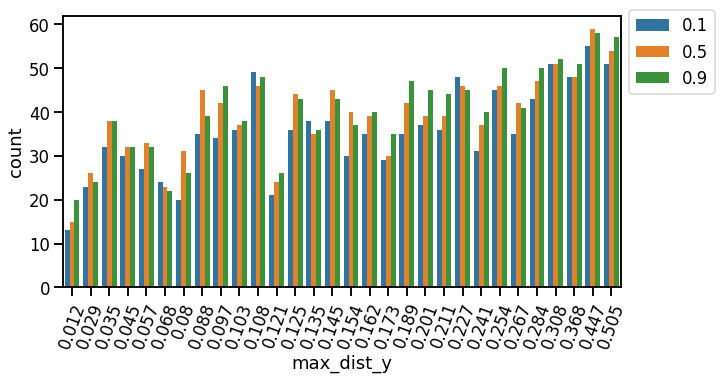

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x="max_dist_y", hue="perc_diploid", data=clonesig_resb[clonesig_resb.sig])
plt.legend(loc=2, bbox_to_anchor=(1,1.05))
plt.xticks(rotation=70, ha='center')

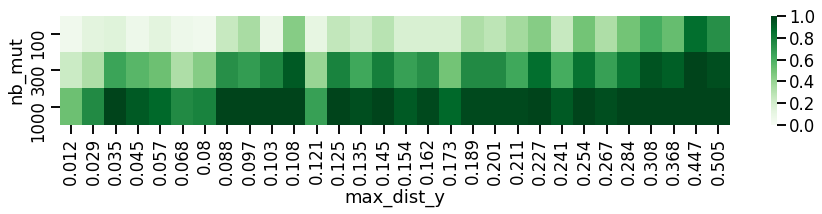

In [6]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )

clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
clonesig_resb['max_dist_y'] = np.round(clonesig_resb['max_dist_y'], 3)
uu=pd.pivot_table(index='nb_mut', columns='max_dist_y', values='sig', aggfunc='sum', data=clonesig_resb) / 60
sns.set_context('talk')
plt.figure(figsize=(15, 2))
sns.heatmap(uu, cmap='Greens', vmin=0, vmax=1)
plt.savefig('20190801_paper_figures/overall_test_sensitivity_nbmut.pdf', bbox_inches='tight')


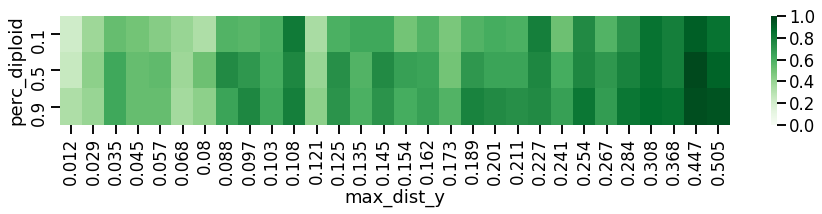

In [7]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )

clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
clonesig_resb['max_dist_y'] = np.round(clonesig_resb['max_dist_y'], 3)
uu=pd.pivot_table(index='perc_diploid', columns='max_dist_y', values='sig', aggfunc='sum', data=clonesig_resb) / 60
sns.set_context('talk')
plt.figure(figsize=(15, 2))
sns.heatmap(uu, cmap='Greens', vmin=0, vmax=1)
plt.savefig('20190801_paper_figures/overall_test_percdip.pdf', bbox_inches='tight')

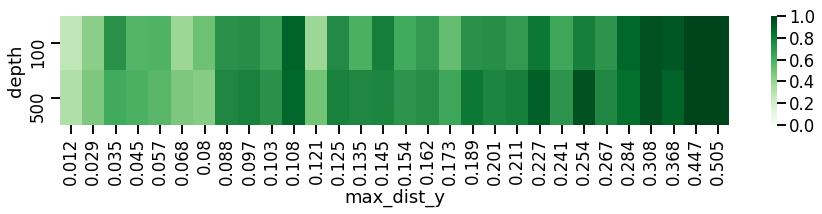

In [8]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )

clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
clonesig_resb['max_dist_y'] = np.round(clonesig_resb['max_dist_y'], 3)
uu=pd.pivot_table(index='depth', columns='max_dist_y', values='sig', aggfunc='sum', data=clonesig_resb) / 80
sns.set_context('talk')
plt.figure(figsize=(15, 2))
sns.heatmap(uu, cmap='Greens', vmin=0, vmax=1)
plt.savefig('20190801_paper_figures/overall_test_sensitivity_depth.pdf', bbox_inches='tight')


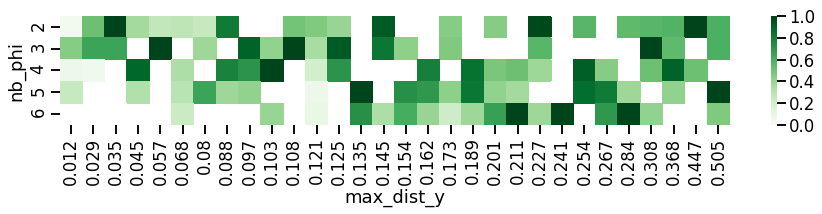

In [9]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )

clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
clonesig_resb['max_dist_y'] = np.round(clonesig_resb['max_dist_y'], 3)
uu=pd.pivot_table(index='nb_phi', columns='max_dist_y', values='sig', aggfunc='sum', data=clonesig_resb) / 60
sns.set_context('talk')
plt.figure(figsize=(15, 2))
sns.heatmap(uu, cmap='Greens', vmin=0, vmax=1)
plt.savefig('20190801_paper_figures/overall_test_nbclones.pdf', bbox_inches='tight')

In [10]:
clonesig_resb.sample(10)

,nb_pi,nb_phi,depth,perc_diploid,nb_clones,nb_mut,nb_sig,nb_sig_fit,min_dist,max_dist_x,avg_dist,avg_major_cn,actual_perc_diploid,avg_tot_cn,method,setting,dof,phi_dist,fitted_nb_clones,ll_ratio,pval,score1B,score1C,score2A,score2C_auc,score2C_accuracy,score2C_sensitivity,score2C_specificity,score2C_precision,score_sig_1A,score_sig_1B,score_sig_1C_auc,score_sig_1C_accuracy,score_sig_1C_sensitivity,score_sig_1C_specificity,score_sig_1C_precision,score_sig_1D,min_diff_distrib_mut,max_diff_distrib_mut,std_diff_distrib_mut,median_diff_distrib_mut,perc_dist_5,perc_dist_10,runtime,timestamp,sig,max_dist_quantized,max_dist_y
4873,27,2,100,0.1,2,300,65,65,0.087757,0.087757,0.087757,2.113333,0.133333,3.240000,clonesig,all,26,-0.900,2,12.762295,7.993216e-01,1.000000,0.981513,0.964196,0.993671,0.993333,0.987342,1.000000,0.987342,0.046414,0.042898,0.993333,0.907692,0.833333,0.900000,0.416667,0.686667,0.041088,0.063476,0.011158,0.041088,0.520000,1.000,188.920153,1.566599e+09,False,7,0.088
2982,16,4,500,0.5,2,1000,65,8,0.010807,0.230136,0.135070,1.597000,0.517000,2.644000,clonesig,prefit,6,-0.300,4,70.688162,4.541475e-09,1.000000,0.989026,0.571195,0.870748,0.904000,0.941497,0.800000,0.941497,0.027782,0.011414,1.000000,0.969231,0.800000,0.967213,0.571429,0.799000,0.003031,0.245869,0.050901,0.006177,0.881000,0.881,1325.227636,1.566591e+09,True,21,0.227
4851,26,6,500,0.1,2,1000,65,65,0.001035,0.103901,0.038201,2.115000,0.110000,3.238000,clonesig,all,26,-0.180,3,86.451536,4.751043e-08,0.571429,0.899552,0.278506,0.765584,0.772000,0.775485,0.755682,0.775485,0.024176,0.017011,0.922131,0.830769,0.600000,0.836066,0.214286,0.633000,0.002333,0.094876,0.017727,0.014438,0.908000,1.000,1157.339959,1.566602e+09,True,9,0.103
2773,15,4,100,0.1,2,100,65,65,0.018322,0.104056,0.045643,2.040000,0.130000,3.140000,clonesig,all,26,-0.300,1,0.002607,1.000000e+00,0.400000,0.700383,0.000000,0.500000,0.250000,0.000000,1.000000,0.000000,0.106709,0.072736,0.824859,0.815385,0.428571,0.847458,0.230769,0.540000,0.055936,0.089304,0.013014,0.062018,0.000000,1.000,78.257298,1.566588e+09,False,9,0.103
2445,13,4,100,0.9,2,1000,65,65,0.044326,0.127488,0.091128,1.056000,0.946000,2.017000,clonesig,all,26,-0.300,3,67.480748,3.027151e-05,0.800000,0.882171,0.495743,0.883566,0.834000,0.787879,0.979253,0.787879,0.024717,0.023927,0.896226,0.630769,0.846154,0.566038,0.314286,0.304000,0.026630,0.185997,0.022028,0.055318,0.402000,0.976,490.629030,1.566588e+09,True,12,0.125
3506,19,4,500,0.1,2,300,65,8,0.026699,0.100647,0.055878,2.090000,0.136667,3.200000,clonesig,prefit,5,-0.300,4,53.909515,1.066563e-06,1.000000,0.972661,0.436473,0.803728,0.853333,0.899123,0.708333,0.899123,0.059546,0.024020,0.893333,0.953846,0.666667,0.966667,0.571429,0.716667,0.005344,0.433313,0.074397,0.020856,0.676667,0.730,308.700031,1.566592e+09,True,9,0.103
4638,25,5,500,0.5,2,1000,65,12,0.015233,0.154156,0.070492,1.590000,0.513000,2.627000,clonesig,prefit,8,-0.225,5,82.289303,1.819711e-08,1.000000,0.959353,0.412432,0.830874,0.892000,0.936629,0.725118,0.936629,0.027915,0.015377,0.921182,0.938462,0.750000,0.948276,0.600000,0.656000,0.004633,0.150465,0.024834,0.024714,0.766000,0.988,1884.130255,1.566601e+09,True,15,0.154
1313,7,3,100,0.5,2,300,65,65,0.090958,0.096364,0.093040,1.563333,0.570000,2.623333,clonesig,all,26,-0.450,3,50.296700,4.767737e-03,1.000000,0.982202,0.661123,0.895939,0.920000,0.965347,0.826531,0.965347,0.054098,0.030079,0.761905,0.615385,0.666667,0.588235,0.312500,0.206667,0.061372,0.155159,0.026864,0.067667,0.000000,0.600,362.055592,1.566582e+09,True,8,0.097
4417,24,4,100,0.1,2,1000,65,65,0.111203,0.293070,0.199922,2.117000,0.105000,3.240000,clonesig,all,26,-0.300,4,125.621402,1.260928e-11,1.000000,0.947745,0.372191,0.795205,0.871000,0.934023,0.656388,0.934023,0.028612,0.017646,0.994048,0.815385,0.900000,0.785714,0.409091,0.499000,0.012229,0.333674,0.079559,0.038179,0.690000,0.692,1034.197791,1.566599e+09,True,26,0.308
3764,20,6,100,0.9,2,300,65,11,0.000760,0.244523,0.106528,1.073333,0.930000,2.0066

In [13]:
clonesig_resb.max_dist_y.count()

5400